In [1]:
from IPython.display import Image

# Introduction to the computational graph and backprop

Diagrams are courtesy of: http://colah.github.io/posts/2015-08-Backprop/

When we write computer programs, we are used to doing computation in a bunch of imperative statements, like so:

In [11]:
def some_function(a,b):
    c = a+b
    d = b+1
    e = c*d
    return e

Let's evaluate on some random inputs:

In [12]:
print some_function(1,1)
print some_function(1,2)
print some_function(3,4)

4
9
35


This function can also be visualised as a graph:

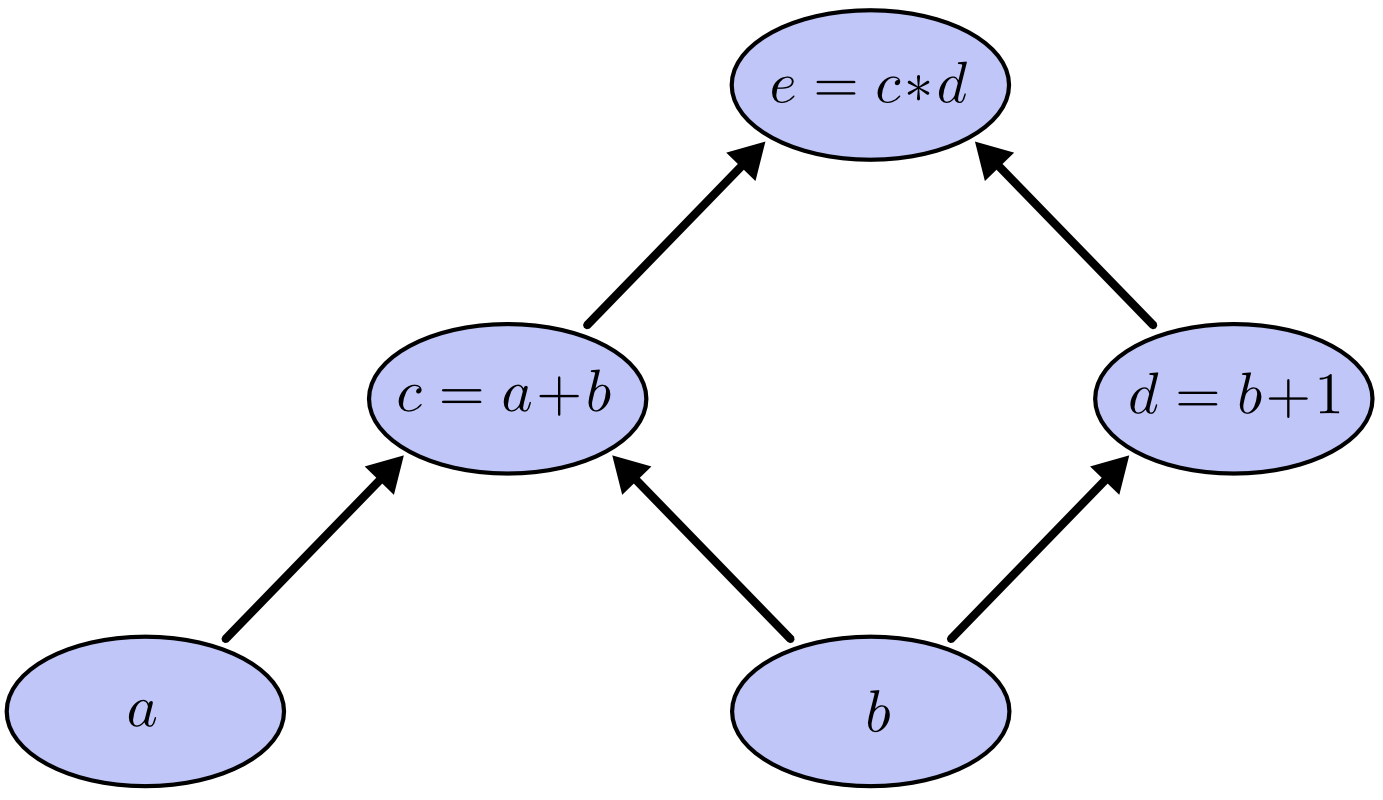

In [5]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-def.png", width=500)

We can also perform the computation of the above function from the bottom-up, which is called a forward pass. Here we will set `a = 2` and `b = 1`

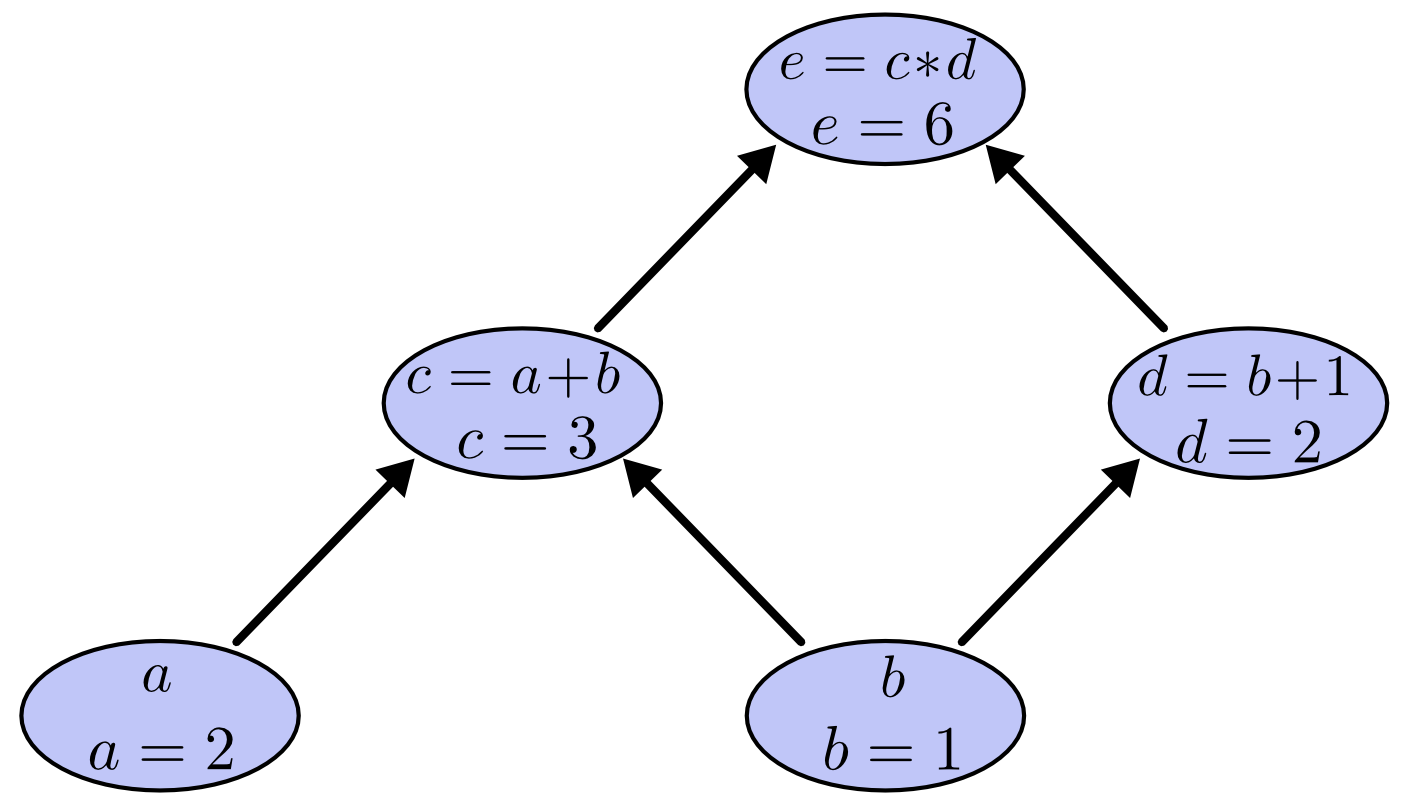

In [9]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-eval.png", width=500)

In [13]:
some_function(2,1)

6

In deep learning, we write models that are expressed in these kinds of computational graphs. Ideally, we'd like to write code like we would in Python -- that is, in an imperative style -- but have the resulting representation be some kind of graph we can traverse.

## Why is this representation useful?

We can compute derivatives easily, in a manner that is local. By 'local', we mean, we can traverse the graph the compute derivatives incrementally, without the considering the graph as a whole.

### Calculus refresher

There are two formulas that are useful to remember, the sum rule, product rule, and the chain rule:

$$ \frac{\partial (a+b)}{\partial a} = \frac{\partial a}{\partial a} + \frac{\partial b}{\partial a}$$

$$ \frac{\partial uv}{u} = u \cdot \frac{\partial v}{\partial u} + v \cdot \frac{\partial u}{\partial u}$$

In the example below, at every edge, we can compute the **derivative of the output of that edge, with respect to the input of that edge.**

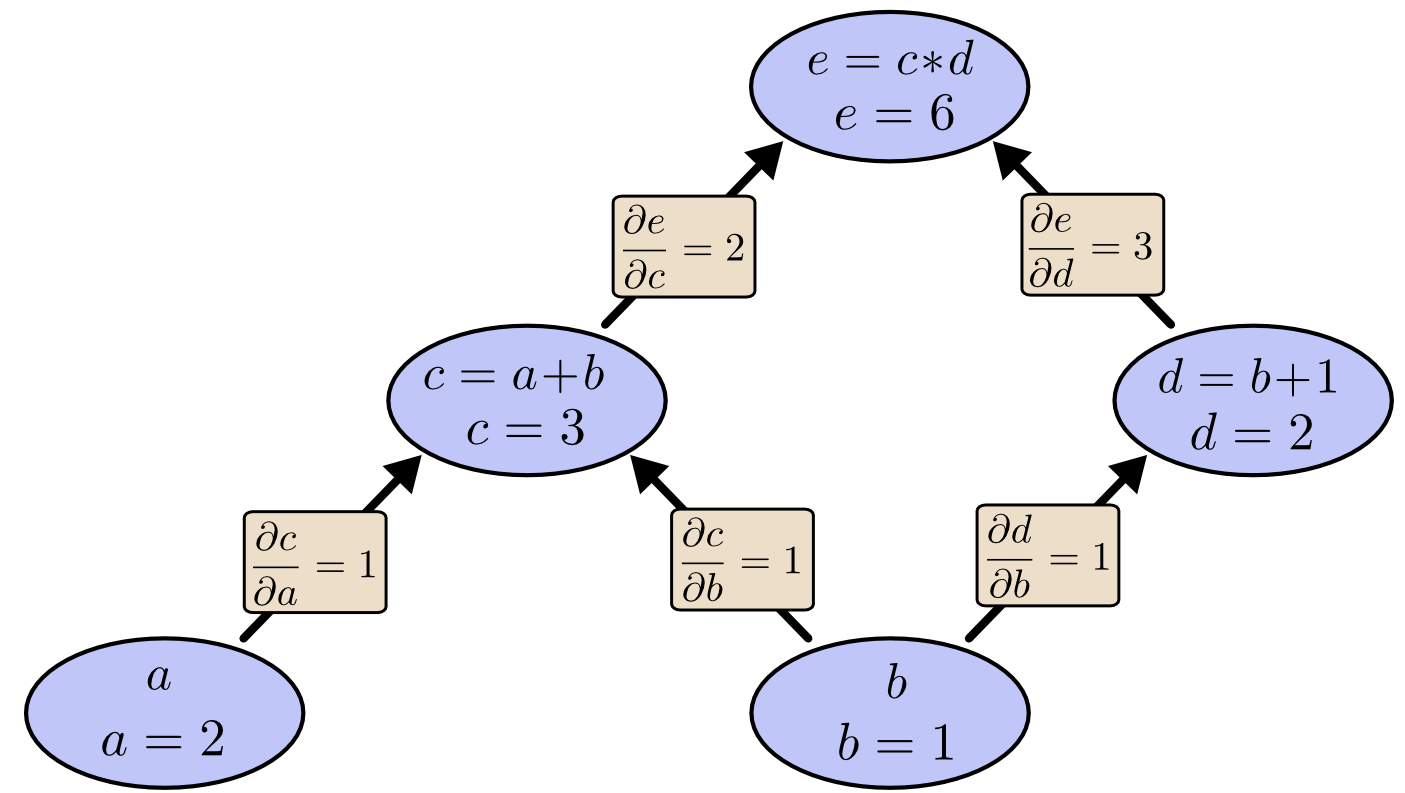

In [18]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png", width=600)

$$ \frac{\partial c}{\partial a} = \frac{\partial (a+b)}{\partial a} = \frac{\partial a}{\partial a} + \frac{\partial b}{\partial a} = 1 + 0 = 1 \ \ \ \ \text{(sum rule)}$$

$$\frac{\partial e}{\partial c} = \frac{\partial cd}{\partial c} = d = 2 \ \ \  \text{(product rule)}$$

What if we wanted to compute the derivative of every expression with respect to the inputs $a$ and $b$?

Currently, the only derivatives we have with respect to the inputs are:
$ \frac{\partial c}{\partial a} $, $ \frac{\partial c}{\partial b}$, and $ \frac{\partial d}{\partial b} $

Let's say we wanted to compute $\frac{\partial e}{\partial b}$. How do we do this? Well, this is where the chain rule comes in! **(Do the diagram on the blackboard)**

$$ \frac{\partial e}{\partial b} = \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial b} = 1 \cdot 3 = 3$$

If you were to apply the chain rule in this fashion, computing the derivative of every node with respect to $a$ and the derivative of every node with respect to $b$, by the time you reached the top of the graph, you would have the derivative of every expression with respect to *all* the inputs. This is called **forward-mode differentiation**.

There is also another form called **reverse-mode differentiation**. In this mode, we don't want the derivative of every expression *with respect to the input* -- we want the derivative of every expression *with respect to the output!*

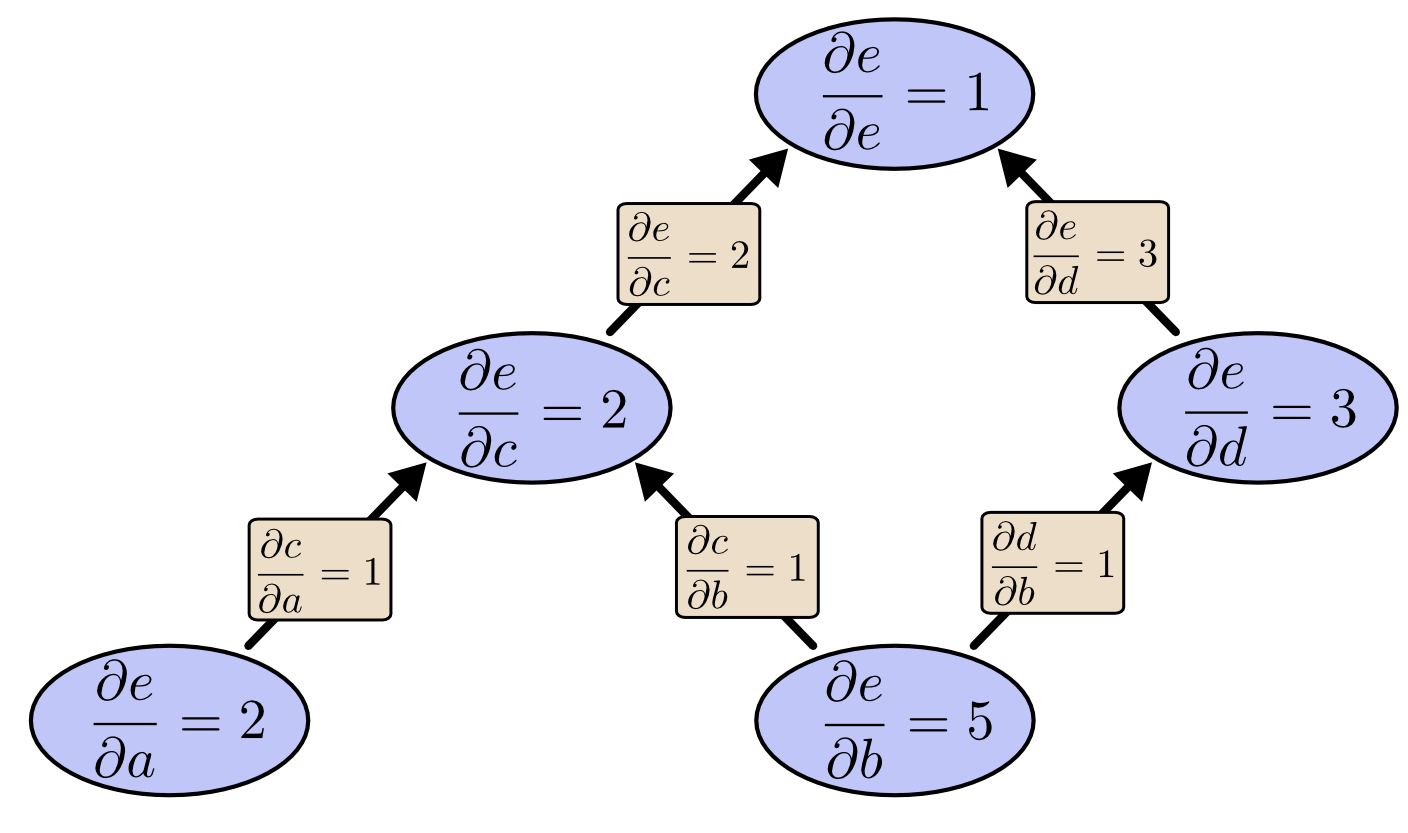

In [19]:
Image("http://colah.github.io/posts/2015-08-Backprop/img/tree-backprop.png", width=600)

This diagram doesn't make it immediately obvious what has just happened, so let's do this on the blackboard so we know how these derivatives were computed.

*Note to myself: mark each derivative as 'we are given', 'we can compute', 'we need'*

At the $d$ node, we are given: $\frac{\partial e}{\partial d}$, and we need to compute $\frac{\partial e}{\partial b}$. So the key ingredient we need to compute is $\frac{\partial d}{\partial b}$, such that:

$$ \frac{\partial e}{\partial b} = \frac{\partial e}{\partial d} \cdot \frac{\partial d}{\partial b} $$

At the $c$ node, we are given: $\frac{\partial e}{\partial c}$, and we need to compute $\frac{\partial e}{\partial b}$. So the key ingredient we need to compute is $\frac{\partial c}{\partial b}$, such that:

$$ \frac{\partial e}{\partial b} = \frac{\partial e}{\partial c} \cdot \frac{\partial c}{\partial b} $$

But hold on a second... now, the $b$ node has two of these $\frac{\partial e}{\partial b}$'s coming to it! Well, we just sum these together!

In deep learning, the parameters that we wish to optimise can be seen as 'inputs' to the graph. So if we can easily compute the derivative of an output with respect to all these parameters, we have an efficient way to optimise our network.

## Scalar linear regression on paper

Let's do the simplest machine learning algorithm that we know: linear regression. In this example, $x$ is a scalar, $w$ is the weight that we learn, and $b$ is the bias/intercept. The optimisation can be framed as this: we want to find the weights $w$ and $b$ such that the loss $(f(x) - y)^2$ is minimised, for training set $\{x_{i},y_{i}\}_{i=1}^{n}$

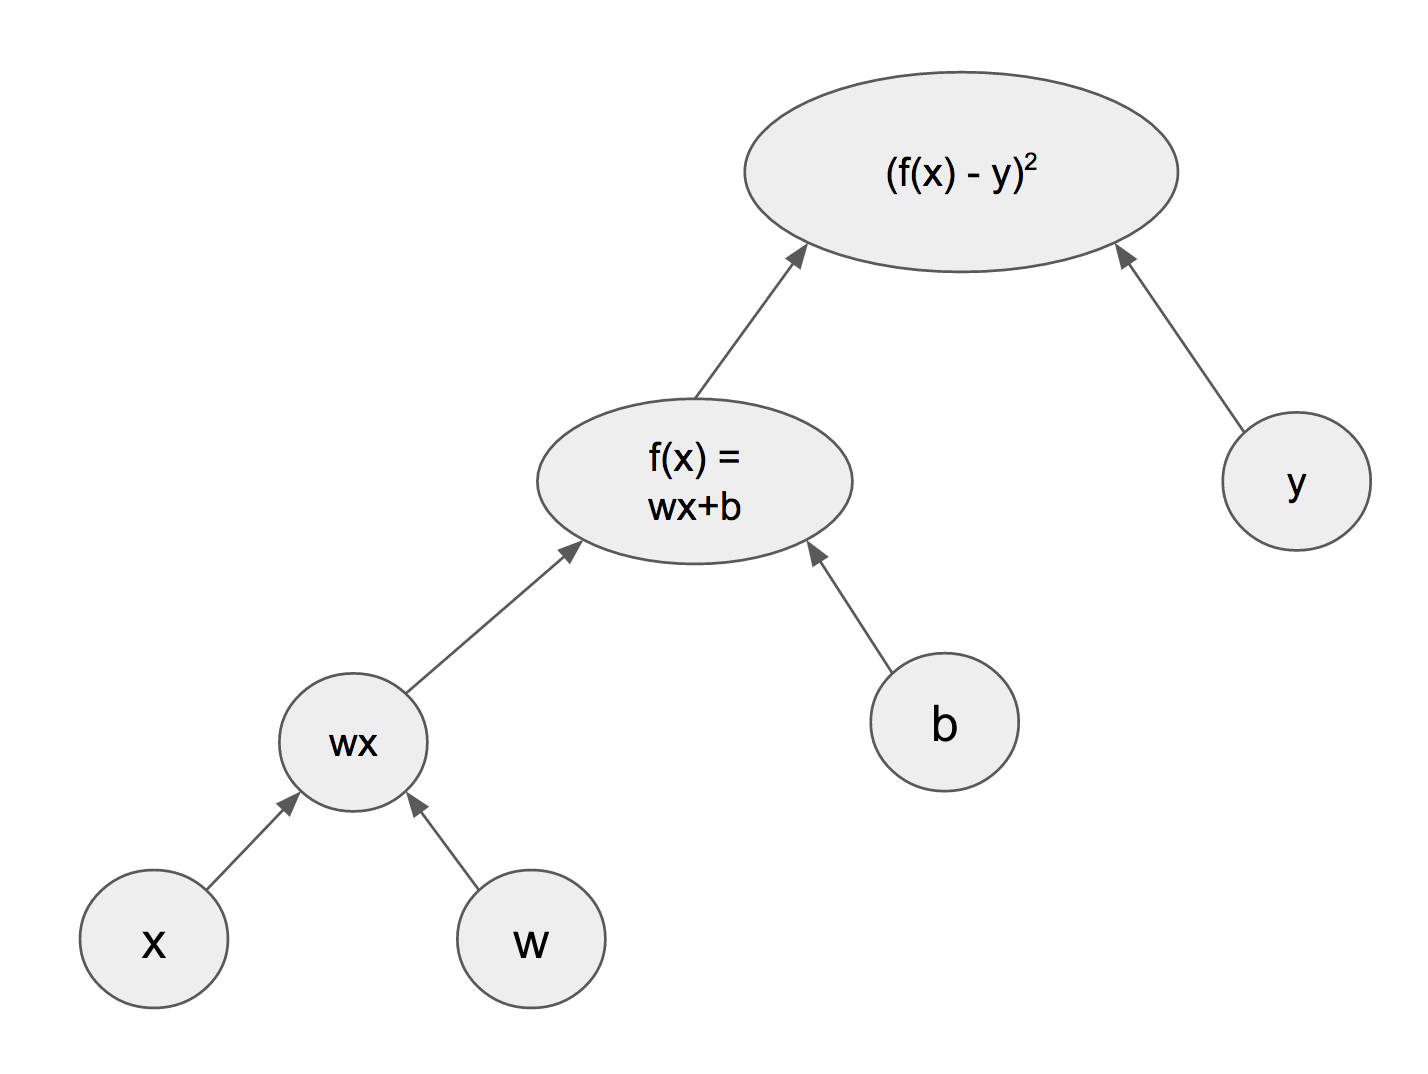

In [10]:
Image("./linear_reg_simple.png", width=700)

*Note to self: draw this on the blackboard and work through it*

We want to be able to compute derivative expressions to update $w$ and $b$. Everything else is irrelevant.

Firstly, we need to compute:
$$ \frac{\partial \ (f(x)-y)^2}{\partial \ f(x)}$$

We can do this via the chain rule:
    
$$ \frac{\partial \ (f(x)-y)^2}{\partial \ f(x)} = \frac{\partial \ (f(x)-y)^2}{\partial \ (f(x)-y)} \cdot \frac{\partial \ (f(x)-y)}{\partial \ f(x)} = 2(f(x) - y) \cdot 1$$  

Now backpropagate this down the path.

Now what we **need** is:
    
$$ \frac{\partial \ (f(x) - y)^2}{\partial \ b} $$

What we got **given to us earlier** was:
    
$$ \frac{\partial \ (f(x) - y)^2}{\partial \ f(x)} $$

What **we have to compute** is therefore is $\frac{\partial \ f(x)}{\partial b}$, and through application of the chain rule we have:

$$ \frac{\partial \ (f(x) - y)^2}{\partial \ b} = \frac{\partial \ (f(x) - y)^2}{\partial \ f(x)} \cdot \frac{\partial \ f(x)}{\partial b} = 2(f(x) - y) \cdot 1$$

We now have an update expression for the bias! We will come back to this later. For now, we need to also compute the same thing for the weight $w$.

-------

What we **need** is:

$$ \frac{\partial \ (f(x) - y)^2}{\partial \ wx} $$

What we got **given to us earlier** was:
    
$$ \frac{\partial \ (f(x) - y)^2}{\partial \ f(x)} $$

What **we have to compute** is therefore is $\frac{\partial \ f(x)}{\partial wx} = \frac{\partial \ wx+b}{\partial \ wx}$, and through application of the chain rule we have:

$$ \frac{\partial \ (f(x) - y)^2}{\partial \ wx} = \frac{\partial \ (f(x) - y)^2}{\partial \ f(x)} \cdot \frac{\partial \ f(x)}{\partial wx} = 2(f(x) - y) \cdot 1$$

----

We just have to do this one more time, and then we are done.

What we **need** is:

$$ \frac{\partial \ (f(x) - y)^2}{\partial \ w} $$

What we got **given to us earlier** was:
    
$$ \frac{\partial \ (f(x) - y)^2}{\partial \ wx} $$

What **we have to compute** is therefore $\frac{\partial \ wx}{\partial \ w}$. So through the chain rule we compute:

$$ \frac{\partial \ (f(x) - y)^2}{\partial \ w} = \frac{\partial \ (f(x) - y)^2}{\partial \ wx} \cdot \frac{\partial \ wx}{\partial w} = 2(f(x) - y) \cdot x$$

-----

Now we have two gradient expressions:
    
$$ \frac{\partial \ (f(x) - y)^2 }{\partial \ w} , \frac{\partial \ (f(x) - y)^2 }{\partial \ b}$$

To find parameters $w$ and $b$ to minimise the loss $(f(x) - y)^2$, we can utilise gradient descent! The expressions we use to iteratively update $w$ and $b$ are:

$$ w := w - \alpha \cdot \frac{\partial \ (f(x) - y)^2 }{\partial \ w} $$

$$ b := b - \alpha \cdot \frac{\partial \ (f(x) - y)^2 }{\partial \ b} ,$$

for some appropriate learning rate $\alpha$. (If we're doing gradient *ascent*, that is, we want to maximise a loss, then we perform addition above rather than subtraction.)

----

So if we have a training set $\{x_{i}, y_{i}\}_{i=1}^{n}$, the pseudocode for the SGD algorithm is as follows:

* Randomly initialise $w$ and $b$
* For epoch in $1, \dots, m$:
  * Randomly shuffle $\{x_{i}, y_{i}\}_{i=1}^{n}$
  * For i in $1, \dots, n$:
    * Compute forward pass for $(f(x_{i}) - y_{i})^2$ (to populate the graph with real values)
    * Compute backward pass, to obtain $ \frac{\partial \ (f(x_{i}) - y_{i})^2 }{\partial \ w} , \frac{\partial \ (f(x_{i}) - y_{i})^2 }{\partial \ b}$
    * Update $w$ and $b$

Note, if we wanted to do batch gradient descent, the naive way to do it would be to average the gradients for $w$ and $b$, that is, compute:

$$ \frac{1}{n} \sum_{i=1}^{n} \frac{\partial \ (f(x_{i}) - y_{i})^2 }{\partial \ w}$$

$$ \frac{1}{n} \sum_{i=1}^{n} \frac{\partial \ (f(x_{i}) - y_{i})^2 }{\partial \ b}$$

But this can be inefficient since you have to do $n$ forward/backward passes through the computational graph. In the example we gave above, we did the derivative computations for just a single example (x,y), but you can generalise it to multiple examples, in which case our derivatives become matrices and vectors (and libraries like Theano and TensorFlow obviously make this really easy). We won't be doing that here (since it gets a bit complex), but to get you used to thinking in terms of matrices and vectors however, I'd like to introduce a little modification to the linear regression example above.

## Vector linear regression on paper

Let's do a little modification to our above example. Before, our $x$ and $w$ were scalars. Now, we let $\mathbf{x}$ be a vector of $p$ features $\{x_{1}, x_{2}, \dots, x_{p}\}$, and likewise for $\mathbf{w} = \mathbf{\theta} = \{\theta_{1}, \theta_{2}, \dots, \theta_{p}\}$. For the sake of simplicity, we omit the intercept, though this can be quite important to have in a regression. The resulting computational graph is shown below.

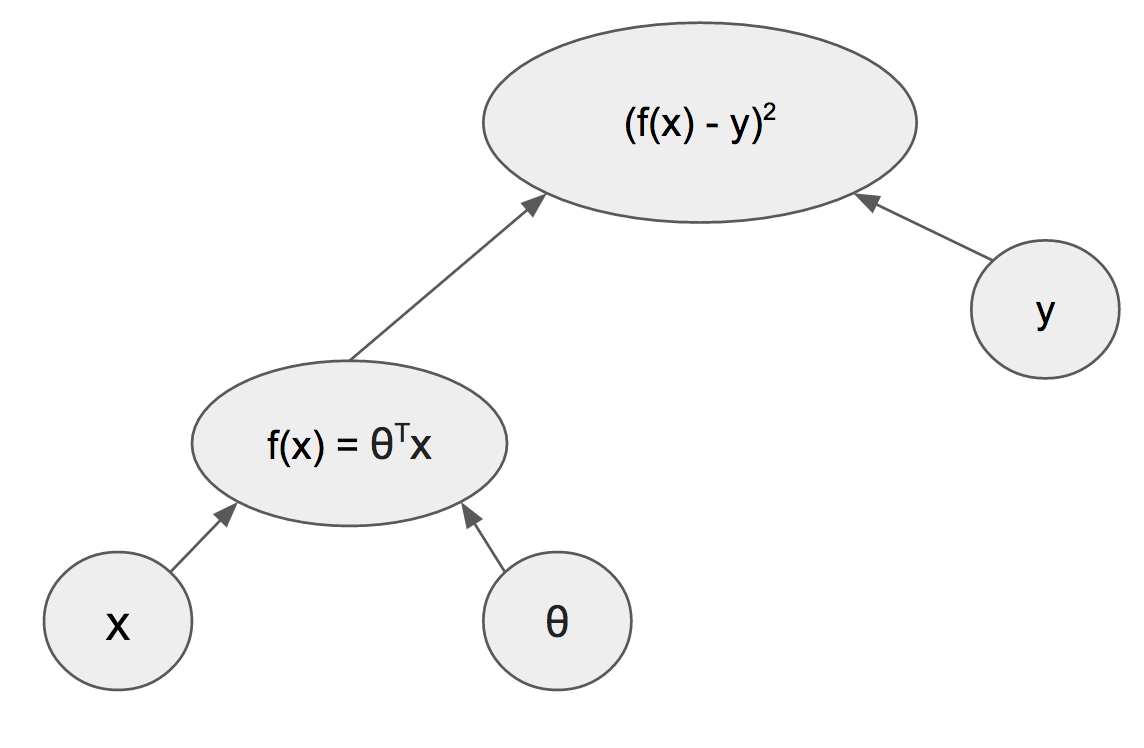

In [16]:
Image("./linear_reg_theta.png", width=600)

Again, let's compute the derivatives that we need to update $\theta$. The first part is easy, and we already did it in the previous example:

$$ \frac{\partial \ (f(\mathbf{x})-y)^2}{\partial \ f(\mathbf{x})} = \frac{\partial \ (f(\mathbf{x})-y)^2}{\partial \ (f(\mathbf{x})-y)} \cdot \frac{\partial \ (f(\mathbf{x})-y)}{\partial \ f(\mathbf{x})} = 2(f(\mathbf{x}) - y) \cdot 1$$  

Now, we need to compute: $$ \frac{\partial \ \mathbf{\theta}^{T}\mathbf{x}}{\partial \ \theta} $$

This derivative expression is slightly different to what we have encountered so far: it is not a scalar! This is actually a vector of derivatives. That is because $\theta^{T}x$ is a scalar (it is the result of a dot product), but $\theta$ is a weight vector that is $p$ units in length. We can expand this term like so:

$$ \frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta} = \Big[ \frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta_{1}}, \dots,  \frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta_{p}} \Big]$$

How do we compute the derivative for the $i$'th element of this vector? We can expand the dot product in the numerator:

$$ \frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta_{i}} = \frac{\partial \ \theta_{1}\mathbf{x}_{1} + \dots + \theta_{i}\mathbf{x}_{i} + \dots + \theta_{p}\mathbf{x}_{p}}{\partial \ \theta_{i}} $$

We notice that in the numerator, only the $\theta_{i}\mathbf{x}_{i}$ term matters, and nothing else. Therefore, we can simplify the expression to:

$$ \frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta_{i}} = \frac{\partial \ \theta_{1}\mathbf{x}_{1} + \dots + \theta_{i}\mathbf{x}_{i} + \dots + \theta_{p}\mathbf{x}_{p}}{d \ \theta_{i}} = \frac{\partial \ \theta_{i}\mathbf{x}_{i}}{\partial \ \theta_{i}} = \mathbf{x}_{i}$$

This means that we can write $\frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta}$ in vector form very easily!

$$ \frac{\partial \ \theta^{T}\mathbf{x}}{\partial \ \theta} = \Big[ \mathbf{x}_{1}, \dots, \mathbf{x}_{p} \Big] = \mathbf{x}$$

We can now write the full expression to compute the gradient of the loss w.r.t. $\theta$.


$$ \frac{\partial \ (f(\mathbf{x}) - y)^2}{\partial \ \theta} = \frac{\partial \ (f(\mathbf{x}) - y)^2}{\partial \ f(\mathbf{x})} \cdot \frac{\partial \ f(\mathbf{x})}{\partial \theta} = 2(f(\mathbf{x}) - y) \cdot \mathbf{x}$$

## Simple linear regression (Theano)

In [2]:
import theano
from theano import tensor as T
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's fit a simple scalar linear regression to some data using Theano.

First, we load in the data and plot what it looks like.

In [15]:
# stealing from data from here:
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/linear_regression.ipynb
X_train = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1], dtype="float32")
y_train = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3], dtype="float32")

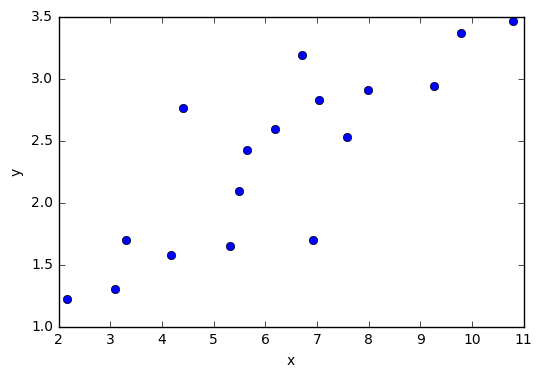

In [25]:
plt.plot(X_train, y_train, "bo")
plt.xlabel('x')
plt.ylabel('y')

First we define our input variables. In this case, it is $x$, and it is a scalar, so we can use `T.fscalar` ('float scalar'):

In [32]:
x = T.fscalar('x')
y = T.fscalar('y')

We also define our weight and intercept, `w` and `b`. These are also Theano variables, but they are a special kind of variable called a 'shared variable' (this is analogous to 'global variables' in typical programming langauges). This means that we can access `w` and `b` like variables without necessarily having to invoke a function.

In [6]:
w = theano.shared(0.0)
b = theano.shared(0.0)

In [31]:
w.get_value(), b.get_value()

(array(0.0), array(0.0))

In [33]:
fx = w*x + b
loss = (fx - y)**2

In [35]:
theano.printing.pydotprint(loss, outfile="t_lin_graph.png", var_with_name_simple=True) 

The output file is available at t_lin_graph.png


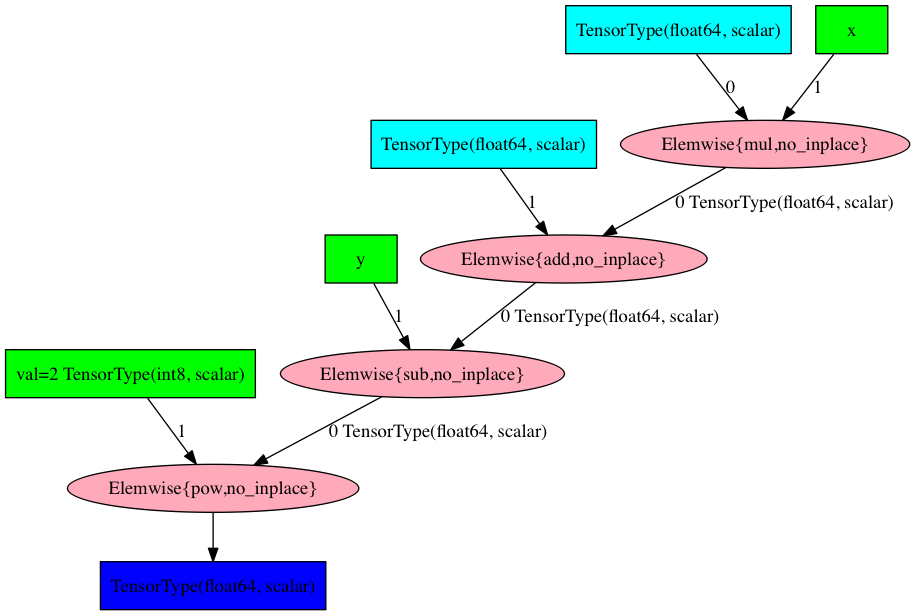

In [38]:
Image("./t_lin_graph.png", width=800)

Before we start computing gradients, let's compile a Theano function we can use to evaluate the model on some examples from the training set.

In [72]:
w.set_value(0.1); b.set_value(0.1)

In [44]:
out_fn = theano.function([x], fx)

In [47]:
out_fn(X_train[0])

array(0.42999999523162846)

Note that we also compute Theano expressions to update the weights $w$ and $b$. We can easily compute gradient expressions for $w$ and $b$ too -- this is ultimately where Theano really shines!

In [42]:
dloss_dw = T.grad(loss, w)
dloss_db = T.grad(loss, b)

We will write a function that will compute the gradient of the loss w.r.t $w$, given some value of $x$.

In [48]:
grad_fn = theano.function([x, y], dloss_dw)

In [49]:
grad_fn(X_train[0], y_train[0])

array(-8.382000225067133)

The `theano.function` can take an argument called `updates`, which is a list of tuples in the form (`param`, `param_update`), where `param` is the (shared Theano) variable we wish to update, and `param_update` tells us specifically how to update/re-assign the variable. I will show this below.

In [73]:
updates = []
learning_rate = theano.shared(0.001)
for param in [w,b]:
    updates.append( (param, param - learning_rate*T.grad(loss, param)))

These tuples are very similar to how you'd write a gradient descent update. The first element of the tuple is our parameter, $\theta$, and the second element of the tuple is $\theta - \alpha \cdot \frac{\partial \ L}{\partial \ \theta}$

In [74]:
train_fn = theano.function([x,y], loss, updates=updates)

----

In [75]:
for epoch in range(0,100):
    losses = []
    for i in range(X_train.shape[0]):
        losses.append(train_fn(X_train[i], y_train[i]))
    print "epoch = %i, avg loss = %f" % (epoch+1, np.mean(losses))

epoch = 1, avg loss = 1.181550
epoch = 2, avg loss = 0.275042
epoch = 3, avg loss = 0.228170
epoch = 4, avg loss = 0.223482
epoch = 5, avg loss = 0.222363
epoch = 6, avg loss = 0.221764
epoch = 7, avg loss = 0.221263
epoch = 8, avg loss = 0.220783
epoch = 9, avg loss = 0.220311
epoch = 10, avg loss = 0.219843
epoch = 11, avg loss = 0.219380
epoch = 12, avg loss = 0.218920
epoch = 13, avg loss = 0.218465
epoch = 14, avg loss = 0.218013
epoch = 15, avg loss = 0.217565
epoch = 16, avg loss = 0.217121
epoch = 17, avg loss = 0.216681
epoch = 18, avg loss = 0.216244
epoch = 19, avg loss = 0.215812
epoch = 20, avg loss = 0.215383
epoch = 21, avg loss = 0.214957
epoch = 22, avg loss = 0.214535
epoch = 23, avg loss = 0.214117
epoch = 24, avg loss = 0.213702
epoch = 25, avg loss = 0.213291
epoch = 26, avg loss = 0.212883
epoch = 27, avg loss = 0.212479
epoch = 28, avg loss = 0.212078
epoch = 29, avg loss = 0.211681
epoch = 30, avg loss = 0.211287
epoch = 31, avg loss = 0.210897
epoch = 32, avg l

In [62]:
b.get_value()

array(0.9159430464533074)

In [77]:
xs = np.linspace(start=2, stop=11)
ys = w.get_value()*xs + b.get_value()

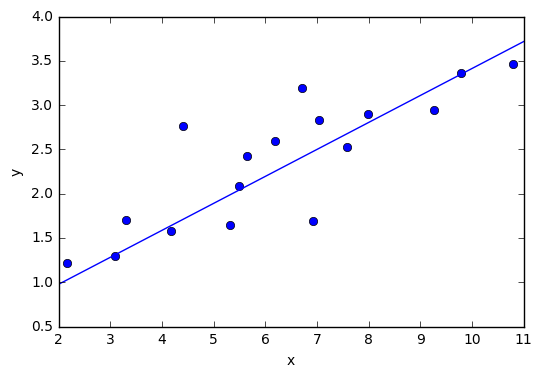

In [78]:
plt.plot(X_train, y_train, "bo")
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('y')

**yayyyyy**

## Vectorised linear regression (Theano)

Earlier, we said that we could potentially do the forward and backward passes in batches. There are three ways to do gradient descent: SGD (one example at a time), mini-batch SGD, or full batch SGD. Full batch SGD requires the most memory, but is precise, in the sense that the gradients computed are averages of the gradients of all the examples in the training set. SGD performs the most 'updates' per epoch, but can be quite noisy since the gradients are computed from single examples. Mini-batch SGD offers a nice trade-off between stable and noisy gradients, and in practice, usually performs faster than SGD due to **fast vectorised implementations and GPUs**.

See also for more information:
* http://sebastianruder.com/optimizing-gradient-descent/
* http://yanran.li/peppypapers/2015/04/11/speed-of-mini-batch-sgd.html

Here, we will write a batched version of our linear regression example above. This implementation takes batches of $\mathbf{x}$ and $\mathbf{y}$ of any size at train/test time.

In [7]:
w.set_value(0.1); b.set_value(0.1) # reset weights

In [8]:
x = T.fmatrix('x') # this is an (n x 1) matrix
y = T.fmatrix('y') # this is an (n x 1) matrix

In [11]:
fx = w*x + b # this is an (n x 1) matrix
loss = (fx - y)**2 # this is an (n x 1) matrix too
loss = loss.mean() # this is a scalar

In [12]:
updates = []
learning_rate = theano.shared(0.001)
for param in [w,b]:
    updates.append( (param, param - learning_rate*T.grad(loss, param)))

In [13]:
train_fn = theano.function([x,y], loss, updates=updates)

In [16]:
X_train.shape, y_train.shape

((17,), (17,))

In [18]:
X_train = X_train.reshape((X_train.shape[0], 1))
y_train = y_train.reshape((y_train.shape[0], 1))

In [19]:
X_train

array([[  3.29999995],
       [  4.4000001 ],
       [  5.5       ],
       [  6.71000004],
       [  6.92999983],
       [  4.16800022],
       [  9.77900028],
       [  6.18200016],
       [  7.59000015],
       [  2.16700006],
       [  7.04199982],
       [ 10.79100037],
       [  5.3130002 ],
       [  7.99700022],
       [  5.65399981],
       [  9.27000046],
       [  3.0999999 ]], dtype=float32)

In [20]:
y_train

array([[ 1.70000005],
       [ 2.75999999],
       [ 2.08999991],
       [ 3.19000006],
       [ 1.69400001],
       [ 1.57299995],
       [ 3.36599994],
       [ 2.59599996],
       [ 2.52999997],
       [ 1.22099996],
       [ 2.8269999 ],
       [ 3.46499991],
       [ 1.64999998],
       [ 2.90400004],
       [ 2.42000008],
       [ 2.94000006],
       [ 1.29999995]], dtype=float32)

Since the dataset is extremely small, we can use full batch SGD. So let's do that here.

In [21]:
losses = []
for epoch in range(100):
    losses.append(train_fn(X_train, y_train))

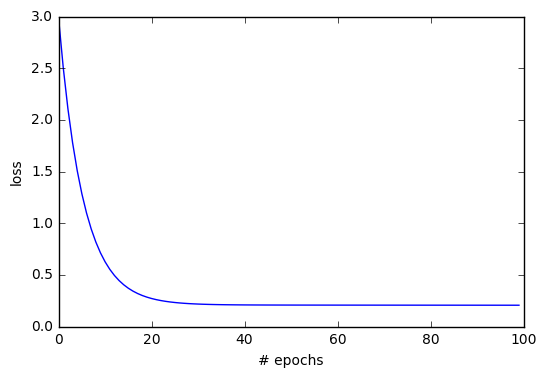

In [24]:
plt.plot(losses)
plt.xlabel('# epochs')
plt.ylabel('loss')

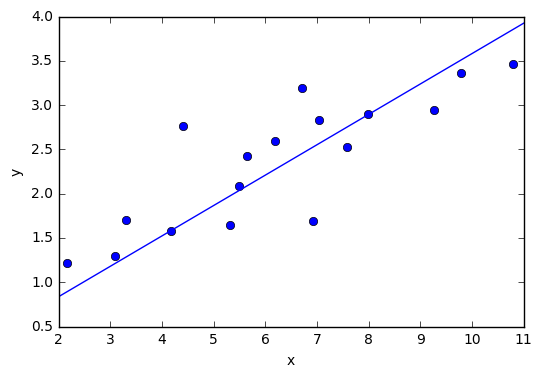

In [25]:
xs = np.linspace(start=2, stop=11)
ys = w.get_value()*xs + b.get_value()
plt.plot(X_train, y_train, "bo")
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('y')

## Binary logistic regression on paper

Here we will define a binary logistic regression and show what the corresponding computational graph and backprop looks like. The loss function for a logistic regression is slightly more complicated so this will be an interesting thing for us to look at.

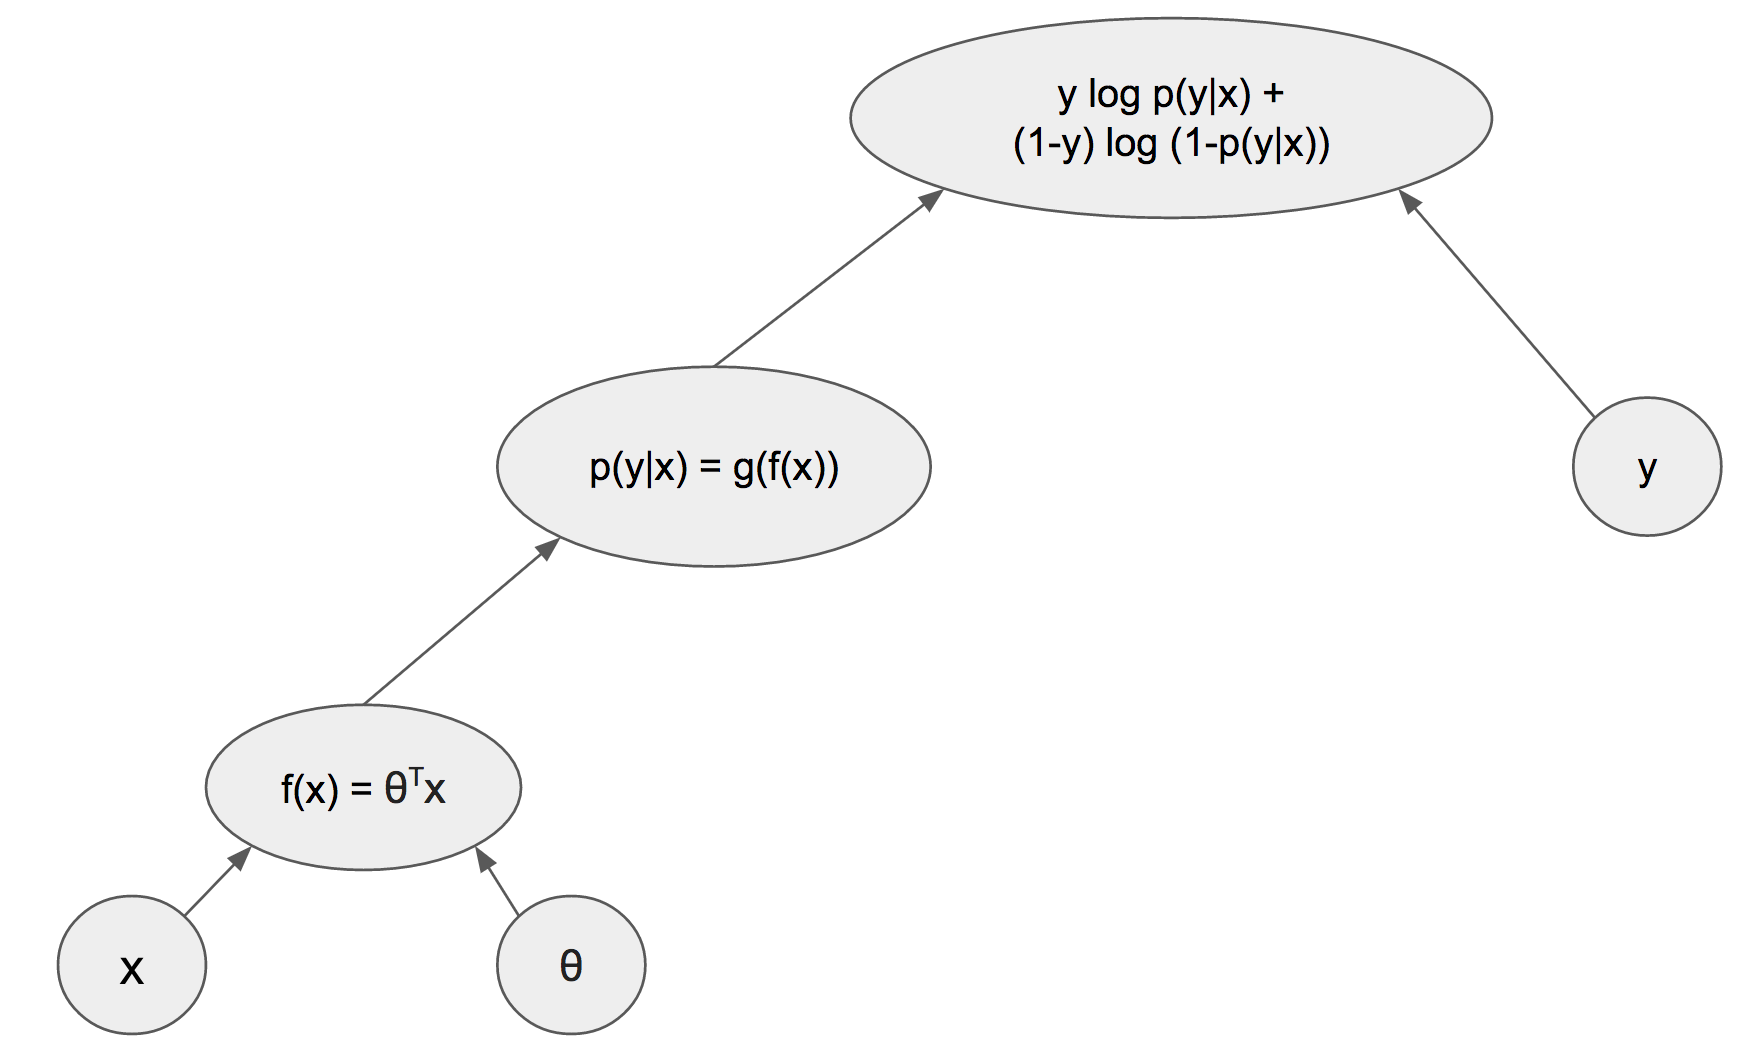

In [5]:
Image("./binary_log_reg.png", width=700)

To be succinct with notation, $\mathbf{x} \in \mathbf{R}^{p}$, $y \in \{0,1\}$, $\theta \in \mathbf{R}^{p}$, and $g(\cdot) = sigm(\cdot)$

$$p(y \ | \ \mathbf{x}) = g( f(\mathbf{x}) ) = g( \theta^{T}\mathbf{x} ),$$

where $g(\theta^{T}x) \in [0,1]$.

We wish to **maximise** the following loss function over all training examples:

$$ \ell(\mathbf{x},y) = y \ log \ p(y|\mathbf{x}) + (1-y) \ log \ (1 - p(y|\mathbf{x}))$$

This is also known as the 'cross-entropy' error, or more specifically, the binary cross-entropy, since $y \in \{0,1\}$ is binary.

### Exercise: compute the derivatives $\frac{\partial \ell}{\partial g(\theta^{T}\mathbf{x})}$ and $\frac{\partial \ell}{\partial \theta^{T}\mathbf{x}}$ (where I have denoted $\ell$ shortland for $\ell(\mathbf{x},y)$)

Solution:

$$
\begin{align}
\frac{\partial \ell}{\partial g(\theta^{T}\mathbf{x})} &= \frac{y}{g(\theta^{T}\mathbf{x})} - \frac{1-y}{1 - g(\theta^{T}\mathbf{x})} \ \ \ \text{(sum rule and chain rule)}\\
&= \frac{y(1 - g(\theta^{T}\mathbf{x})) - (1-y)g(\theta^{T}\mathbf{x})}{g(\theta^{T}\mathbf{x})(1 - g(\theta^{T}\mathbf{x}))} \ \ \ \text{(cross-multiplying)} \\
&= \frac{y - yg(\theta^{T}\mathbf{x}) - g(\theta^{T}\mathbf{x}) + y g(\theta^{T}\mathbf{x})}{g(\theta^{T}\mathbf{x})(1 - g(\theta^{T}\mathbf{x}))} \ \ \ \text{(expanding terms)} \\
&= \frac{y - g(\theta^{T}\mathbf{x})}{g(\theta^{T}\mathbf{x})(1 - g(\theta^{T}\mathbf{x}))} \ \ \ \text{(simplification)}
\end{align}
$$

The bottom term is actually the derivative of the sigmoid function! As we will see very shortly, we will be able to cancel out this term when we compute $\frac{\partial \ell}{\partial \theta^{T}\mathbf{x}}$.

From the chain rule:

$$
\begin{align}
\frac{\partial \ell}{\partial \theta^{T}\mathbf{x}} &= \frac{\partial \ell}{\partial g(\theta^{T}\mathbf{x})} \cdot \frac{\partial g(\theta^{T}\mathbf{x})}{\partial \theta^{T}\mathbf{x}} \\
&= \frac{y - g(\theta^{T}\mathbf{x})}{g(\theta^{T}\mathbf{x})(1 - g(\theta^{T}\mathbf{x}))} \cdot g(\theta^{T}\mathbf{x})(1 - g(\theta^{T}\mathbf{x})) \\
&= y - g(\theta^{T}\mathbf{x})
\end{align}
$$

This gives us a very nice interpretation of the derivative of the loss w.r.t. $\theta^{T}\mathbf{x}$! The error signal that is backpropagated is proportional to the difference between $y$ and $g(\theta^{T}\mathbf{x})$. If these are the same (= 0), then no signal is necessary to propagate backward.

## Multinomial logistic regression on MNIST (Theano)

We are now going to run a multi-class logistic regression example in Theano for MNIST digits classification. We will need to modify the math of our binary logistic regression example above (since this is a multi-class problem), but after this we will be able to jump right into the Theano code.

$\mathbf{X} \in \mathbf{R}^{n \times p}, \mathbf{Y} \in \{0,1\}^{n \times k}$, where $n$ is the number of examples / mini-batch size, $p$ is the number of features, and $k$ the number of classes.

$$ p(\mathbf{y} \ | \ \mathbf{X}) = g(\mathbf{X} \mathbf{W} + \mathbf{b}), $$

where $\mathbf{W} \in \mathbf{R}^{p \times k}$ and $\mathbf{b} \in \mathbf{R}^{1 \times k}$, and $g(\cdot) = softmax(\cdot)$

The loss we wish to maximise is:

$$ \frac{1}{n} \sum_{i=1}^{n} \Big[ \sum_{j=1}^{k} \mathbf{y}_{i,j} \ log \ p(\mathbf{y}_{i} \ | \ \mathbf{X}_{i})_{j} \Big]$$

...which is the same as minimising the negative sum:

$$ \frac{1}{n} \sum_{i=1}^{n} \Big[ -\sum_{j=1}^{k} \mathbf{y}_{i,j} \ log \ p(\mathbf{y}_{i} \ | \ \mathbf{X}_{i})_{j} \Big]$$

In [3]:
X = T.fmatrix('X') # this is a matrix of size (n, p)
Y = T.fmatrix('Y') # this is a one-hot matrix of size (n,k)

In [4]:
W = theano.shared(np.random.normal(0,0.01,size=(784, 10))) # matrix of size (p,k)
b = theano.shared(np.zeros((10,))) #

In [5]:
preds = T.nnet.softmax( T.dot(X,W) + b )

In [6]:
loss = T.nnet.categorical_crossentropy(preds, Y)
loss = loss.mean()

In [117]:
theano.printing.pydotprint(loss, outfile="softmax_graph.png", var_with_name_simple=True) 

The output file is available at softmax_graph.png


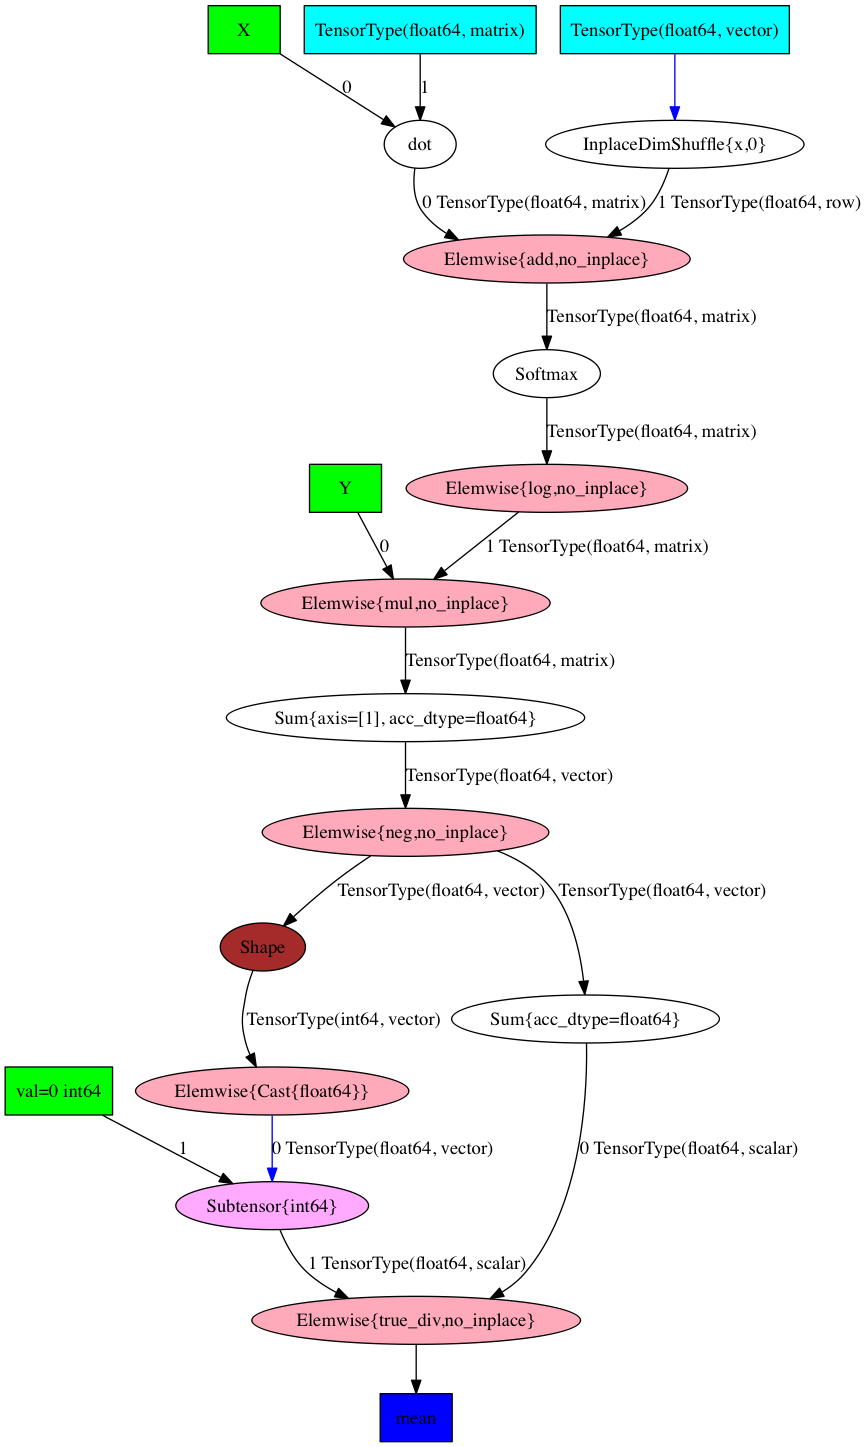

In [118]:
Image("./softmax_graph.png", width=600)

In [7]:
updates = []
learning_rate = 0.01
for param in [W,b]:
    updates.append( (param, param-learning_rate*T.grad(loss, param)))

In [8]:
updates

[(<TensorType(float64, matrix)>, Elemwise{sub,no_inplace}.0),
 (<TensorType(float64, vector)>, Elemwise{sub,no_inplace}.0)]

In [9]:
accuracy = T.eq(T.argmax(preds,axis=1), T.argmax(Y,axis=1)).mean()

----------

Now we load the data. I have created a helper module called `datasets.py`, which has a method called `load_mnist()`.

In [16]:
import datasets
X_train, y_train, X_valid, y_valid, _, _ = datasets.load_mnist()

In [11]:
X_train.shape, y_train.shape

((50000, 1, 28, 28), (50000, 10))

In [17]:
X_train.dtype, y_train.dtype

(dtype('float32'), dtype('float32'))

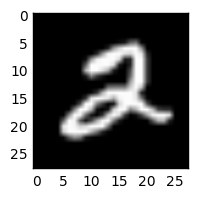

In [13]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[5][0], cmap="gray")

In [45]:
y_train[5]

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Slight technicality: we're not doing conv-nets yet, so we have to flatten the (1,28,28) vector into (784,)

In [19]:
X_train = X_train.reshape((X_train.shape[0], 1*28*28))
X_valid = X_valid.reshape((X_valid.shape[0], 1*28*28))

In [15]:
train_fn = theano.function([X,Y], [loss, accuracy], updates=updates)

In [19]:
loss_fn = theano.function([X,Y], [loss, accuracy])

To keep things fast on my poor Macbook, we'll train on just the first 10,000 examples in the training set.

In [25]:
for epoch in range(50):
    train_losses = []
    train_accuracies = []
    for X_batch, y_batch in datasets.iterator(X_train[0:10000], y_train[0:10000], bs=32, shuffle=True):
        this_loss, this_accuracy = train_fn(X_batch, y_batch)
        train_losses.append(this_loss)
        train_accuracies.append(this_accuracy)
    valid_losses = []
    valid_accuracies = []
    for X_batch, y_batch in datasets.iterator(X_valid, y_valid, bs=32, shuffle=False):
        this_loss, this_accuracy = train_fn(X_batch, y_batch)
        valid_losses.append(this_loss)
        valid_accuracies.append(this_accuracy)
    print "epoch = %i, train loss = %f, train acc = %f, valid loss = %f, valid acc = %f" % \
        (epoch+1, np.mean(train_losses), np.mean(train_accuracies), np.mean(valid_losses), np.mean(valid_accuracies))

epoch = 1, train loss = 0.350813, train acc = 0.904752, valid loss = 0.328218, valid acc = 0.912939
epoch = 2, train loss = 0.345030, train acc = 0.907248, valid loss = 0.323396, valid acc = 0.914736
epoch = 3, train loss = 0.340931, train acc = 0.907748, valid loss = 0.319138, valid acc = 0.915835
epoch = 4, train loss = 0.335755, train acc = 0.908846, valid loss = 0.315232, valid acc = 0.916034
epoch = 5, train loss = 0.331963, train acc = 0.910044, valid loss = 0.311709, valid acc = 0.916733
epoch = 6, train loss = 0.328322, train acc = 0.912041, valid loss = 0.308472, valid acc = 0.917432
epoch = 7, train loss = 0.324909, train acc = 0.913339, valid loss = 0.305454, valid acc = 0.918231
epoch = 8, train loss = 0.321567, train acc = 0.913339, valid loss = 0.302630, valid acc = 0.919429
epoch = 9, train loss = 0.319132, train acc = 0.913838, valid loss = 0.300055, valid acc = 0.919529
epoch = 10, train loss = 0.316046, train acc = 0.914736, valid loss = 0.297686, valid acc = 0.919728

We can use the `eval` function to evaluate parts of the graph (which requires less typing than for a Theano function). Note: this is good for testing, but has more overhead than a regular `theano.function`, so only use it for testing!

In [46]:
py_test = preds.eval({X:X_train[0:1]})
py_test[0]

array([  2.71788561e-03,   4.63789930e-05,   3.80291758e-03,
         2.94843759e-01,   4.17131270e-06,   6.89068028e-01,
         7.73307060e-04,   2.38028667e-03,   4.07344824e-03,
         2.28981744e-03])

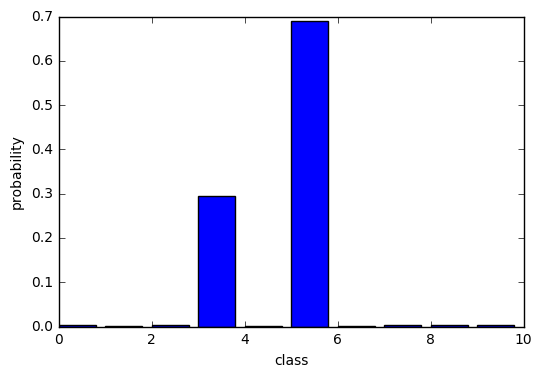

In [48]:
plt.bar( height=py_test[0], left=range(10) )
plt.xlabel('class')
plt.ylabel('probability')

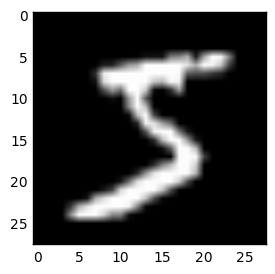

In [52]:
plt.figure(figsize=(3,3))
plt.imshow(X_train[0].reshape((28,28)), cmap="gray")

### Exercise: extend this code so that you have a neural network with one or two hidden layers. Write out the math for it first, then 'port' it to Theano code.

-----

## Libraries on top of Theano

I will introduce two libraries that abstract neural networks for Theano:
* [Lasagne](https://github.com/Lasagne/Lasagne)
* [Keras](https://github.com/fchollet/keras)

Both have slightly different design philosophies, and if you get the chance you should try both to see which one you are more comfortable with.

### Lasagne

Lasagne is a lightweight wrapper for Theano that provides easy-to-use building blocks for deep neural networks. Its design philosophy emphasises that the underlying implementation (that is, Theano) be easy to access, and therefore it can be seen as a library of many useful helper functions.

Make sure you have the latest version of Theano, then install Lasagne from here:
* https://github.com/Lasagne/Lasagne
(Note: do not install Lasagne from `pip`'s own repository!)

In [3]:
import lasagne

X = T.fmatrix('X') # this is a matrix of size (n, p)
Y = T.fmatrix('Y') # this is a one-hot matrix of size (n,k)

l_in = lasagne.layers.InputLayer((None, 784))
l_out = lasagne.layers.DenseLayer(l_in, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

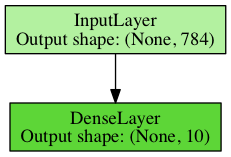

In [5]:
# requires nolearn library to visualise network!!
# https://github.com/dnouri/nolearn/
import nolearn
from nolearn.lasagne.visualize import draw_to_notebook

draw_to_notebook(lasagne.layers.get_all_layers(l_out))

In [7]:
l_out.W.get_value().shape, l_out.b.get_value().shape

((784, 10), (10,))

In [9]:
predictions = lasagne.layers.get_output(l_out, X)
loss = lasagne.objectives.categorical_crossentropy(predictions, Y)
loss = loss.mean()

In [10]:
params = lasagne.layers.get_all_params(l_out, trainable=True)
params

[W, b]

In [12]:
accuracy = T.eq(T.argmax(predictions,axis=1), T.argmax(Y,axis=1)).mean()

In [13]:
updates = lasagne.updates.sgd(loss, params, learning_rate=0.01)
updates

OrderedDict([(W, Elemwise{sub,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0)])

In [14]:
train_fn = theano.function([X,Y], [loss, accuracy], updates=updates)

In [20]:
for epoch in range(10):
    train_losses = []
    train_accuracies = []
    for X_batch, y_batch in datasets.iterator(X_train[0:10000], y_train[0:10000], bs=32, shuffle=True):
        this_loss, this_accuracy = train_fn(X_batch, y_batch)
        train_losses.append(this_loss)
        train_accuracies.append(this_accuracy)
    valid_losses = []
    valid_accuracies = []
    for X_batch, y_batch in datasets.iterator(X_valid, y_valid, bs=32, shuffle=False):
        this_loss, this_accuracy = train_fn(X_batch, y_batch)
        valid_losses.append(this_loss)
        valid_accuracies.append(this_accuracy)
    print "epoch = %i, train loss = %f, train acc = %f, valid loss = %f, valid acc = %f" % \
        (epoch+1, np.mean(train_losses), np.mean(train_accuracies), np.mean(valid_losses), np.mean(valid_accuracies))

epoch = 1, train loss = 1.463243, train acc = 0.631589, valid loss = 0.806880, valid acc = 0.841753
epoch = 2, train loss = 0.667212, train acc = 0.847644, valid loss = 0.556723, valid acc = 0.871206
epoch = 3, train loss = 0.538171, train acc = 0.866314, valid loss = 0.475913, valid acc = 0.884685
epoch = 4, train loss = 0.480001, train acc = 0.878395, valid loss = 0.433687, valid acc = 0.889976
epoch = 5, train loss = 0.445376, train acc = 0.885184, valid loss = 0.406919, valid acc = 0.895567
epoch = 6, train loss = 0.422357, train acc = 0.890176, valid loss = 0.387857, valid acc = 0.899860
epoch = 7, train loss = 0.404585, train acc = 0.893970, valid loss = 0.373468, valid acc = 0.903854
epoch = 8, train loss = 0.391222, train acc = 0.895867, valid loss = 0.362154, valid acc = 0.906050
epoch = 9, train loss = 0.379808, train acc = 0.897065, valid loss = 0.352832, valid acc = 0.908446
epoch = 10, train loss = 0.370661, train acc = 0.898762, valid loss = 0.345036, valid acc = 0.910044

Notice how, despite having saved a lot of effort in defining a model and training it, we still had to write quite a bit our code ourselves, namely, the training loop and the necessary outputs such as the `loss`, `predictions`, and `accuracy`. If you prefer to go one layer of abstraction up, then Keras might be a good bet!

### Keras

Keras provides a much higher level of abstraction than Lasagne does. The good thing is that it's much easier and faster to define models, but the bad thing is that this can potentially hinder flexibility depending on what you're doing (though that is not to say Keras is not as flexible as Lasagne -- they are both heavily used in research).

There are basically two ways to define Keras models: using the sequential API, and the functional API. The latter is slightly more verbose and is mainly suited toward more exotic neural network archictures, so we'll use the simpler sequential API.

Make sure you have the latest version of Theano, then install Lasagne from here:
* https://github.com/fchollet/keras
(Note: do not install Keras from `pip`'s own repository!)

In [21]:
import keras

Using TensorFlow backend.


In [22]:
model = keras.models.Sequential()
model.add( keras.layers.Dense(10, input_dim=784) )
model.add( keras.layers.Activation('softmax') )

In [23]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(X_train[0:10000], y_train[0:10000], nb_epoch=10, batch_size=32, validation_data=(X_valid,y_valid))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s - loss: 1.4815 - acc: 0.6317 - val_loss: 0.9799 - val_acc: 0.8205

...are you freaking kidding me?!?!